In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
import zipfile

with zipfile.ZipFile('/content/drive/MyDrive/homer_bart.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/new')

Shape of Sample Image: (64, 64)


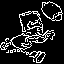

In [15]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from google.colab.patches import cv2_imshow  # Import cv2_imshow for Colab

# Function to load images from folder and apply featurization
def load_images_and_featurize(folder_path, label):
    images = []
    labels = []
    for filename in os.listdir(folder_path):
        img_path = os.path.join(folder_path, filename)
        if img_path.endswith(".bmp"):
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Read image in grayscale
            if img is not None:
                img = cv2.resize(img, (64, 64))  # Resize image to 64x64
                # Apply Canny edge detection
                edges = cv2.Canny(img, 100, 200)
                images.append(edges)  # Append processed image
                labels.append(label)  # Append corresponding label (0 for Bart, 1 for Homer)
    return images, labels

# Paths to Bart and Homer folders
bart_folder = "/content/Bart"
homer_folder = "/content/Homer"

# Load Bart images and assign label 0
bart_images, bart_labels = load_images_and_featurize(bart_folder, 0)

# Load Homer images and assign label 1
homer_images, homer_labels = load_images_and_featurize(homer_folder, 1)

# Concatenate Bart and Homer data
images = np.array(bart_images + homer_images)
labels = np.array(bart_labels + homer_labels)

# Split data into train and test sets (0.9 train, 0.1 test)
train_images, test_images, train_labels, test_labels = train_test_split(images, labels, test_size=0.1, random_state=42)

# Function to visualize featurized image
def visualize_featurized_image(image):
    cv2_imshow(image)  # Display image in Colab

# Sample image for visualization
sample_image = train_images[5]

# Print shape of sample image
print("Shape of Sample Image:", sample_image.shape)

# Visualize featurized sample image
visualize_featurized_image(sample_image)


In [56]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout

def build_custom_model(input_shape, output_size, hidden_layers):

    model = Sequential()
    model.add(Flatten(input_shape=input_shape))  # Flatten the input image

    # Add hidden layers based on the provided configuration
    for units in hidden_layers:
        model.add(Dense(units, activation='relu'))  # Dense layer with ReLU activation
        model.add(Dropout(0.5))  # Dropout layer for regularization

    model.add(Dense(output_size, activation='sigmoid'))  # Output layer with sigmoid activation

    # Compile the model
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    return model

# Example usage:
input_shape = (64, 64)  # Example input shape for 64x64 images
output_size = 1  # Output size (1 for binary classification)
hidden_layers = [256, 128, 64]  # Example hidden layer configuration [128 neurons, 64 neurons]

# Build the model
custom_model = build_custom_model(input_shape, output_size, hidden_layers)

# Print model summary
custom_model.summary()


Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_9 (Flatten)         (None, 4096)              0         
                                                                 
 dense_37 (Dense)            (None, 256)               1048832   
                                                                 
 dropout_28 (Dropout)        (None, 256)               0         
                                                                 
 dense_38 (Dense)            (None, 128)               32896     
                                                                 
 dropout_29 (Dropout)        (None, 128)               0         
                                                                 
 dense_39 (Dense)            (None, 64)                8256      
                                                                 
 dropout_30 (Dropout)        (None, 64)               

In [57]:
from tensorflow.keras.callbacks import ModelCheckpoint
checkpoint_path = "best_model.h5"
checkpoint_callback = ModelCheckpoint(filepath=checkpoint_path,
                                      monitor='val_accuracy',  # Monitor validation accuracy
                                      verbose=1,
                                      save_best_only=True,
                                      mode='max')  # Save the model with the highest validation accuracy
# Train the model without validation split
# history = custom_model.fit(train_images, train_labels, epochs=500, batch_size = 32)

In [58]:
# Train the model with validation split
history = custom_model.fit(train_images, train_labels, epochs=300,
                    validation_split=0.1,  # 10% of training data for validation
                    callbacks=[checkpoint_callback])



Epoch 1/300
6/7 [========================>.....] - ETA: 0s - loss: 105.4208 - accuracy: 0.4375
Epoch 1: val_accuracy improved from -inf to 0.60000, saving model to best_model.h5
7/7 [==============================] - 2s 98ms/step - loss: 102.5753 - accuracy: 0.4608 - val_loss: 14.1177 - val_accuracy: 0.6000
Epoch 2/300
7/7 [==============================] - ETA: 0s - loss: 71.0625 - accuracy: 0.5622
Epoch 2: val_accuracy did not improve from 0.60000
7/7 [==============================] - 0s 30ms/step - loss: 71.0625 - accuracy: 0.5622 - val_loss: 9.1920 - val_accuracy: 0.5200
Epoch 3/300
7/7 [==============================] - ETA: 0s - loss: 64.6410 - accuracy: 0.5576
Epoch 3: val_accuracy improved from 0.60000 to 0.64000, saving model to best_model.h5
7/7 [==============================] - 0s 48ms/step - loss: 64.6410 - accuracy: 0.5576 - val_loss: 14.7550 - val_accuracy: 0.6400
Epoch 4/300
7/7 [==============================] - ETA: 0s - loss: 50.1447 - accuracy: 0.5438
Epoch 4: val_

In [59]:
# Load the best model based on validation accuracy
best_model = tf.keras.models.load_model(checkpoint_path)

# Evaluate the best model on test set
loss, accuracy = best_model.evaluate(test_images, test_labels)

print(f"Test Accuracy of Best Model: {accuracy*100:.2f}%")

1/1 [==============================] - 0s 175ms/step - loss: 11.3044 - accuracy: 0.8148
Test Accuracy of Best Model: 81.48%


In [60]:

import numpy as np

# Evaluate the model on test set
loss, accuracy = custom_model.evaluate(test_images, test_labels, verbose=0)

print(f"Test Accuracy: {accuracy*100:.2f}%")

Test Accuracy: 85.19%
